In [34]:
# ==============================================
# Sezione 1: Importazioni e configurazioni base
# ==============================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import shuffle
from itertools import product
import time
from typing import Dict, List, Any, Union
from google.colab import drive
import logging
from dataclasses import dataclass

# Configurazione logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configurazioni di stile
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})
sns.set_palette("tab10")

In [47]:
# ==============================================
# Sezione 2: Definizione di classi e funzioni
# ==============================================

@dataclass
class TrainingResult:
    """Classe per memorizzare i risultati dell'addestramento"""
    model: MLPClassifier
    train_acc: float
    val_acc: float
    params: Dict[str, Any]
    training_time: float
    loss_curve: Union[List[float], None]
    training_scores: Union[List[float], None]
    validation_scores: Union[List[float], None]

def convert_to_grayscale(image: np.ndarray) -> np.ndarray:
    """Converte un'immagine a colori in scala di grigi"""
    return np.dot(image[..., :3], [0.299, 0.587, 0.114])

def grayscale_dataset(images: np.ndarray) -> np.ndarray:
    """Applica la conversione in scala di grigi a un intero dataset"""
    return np.array([convert_to_grayscale(img) for img in images])

def plot_examples(orig: np.ndarray, grayscale: np.ndarray,
                 y: np.ndarray, class_names: List[str],
                 num_samples: int = 5, random_state: int = 42) -> None:
    """Mostra confronto tra immagini originali e in scala di grigi"""
    np.random.seed(random_state)
    indices = np.random.choice(len(orig), size=num_samples, replace=False)

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))
    fig.suptitle("Confronto immagini originali e in scala di grigi", y=1.05)

    for i, idx in enumerate(indices):
        axes[0, i].imshow(orig[idx])
        axes[0, i].set_title(f"Originale: {class_names[y[idx]]}")
        axes[0, i].axis('off')

        axes[1, i].imshow(grayscale[idx], cmap='gray')
        axes[1, i].set_title(f"Scala di grigi: {class_names[y[idx]]}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

def plot_training_curves(result: TrainingResult, ax: plt.Axes = None) -> None:
    """Visualizza le curve di apprendimento per un singolo modello"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    if result.loss_curve is None:
        ax.text(0.5, 0.5, "Dati di training non disponibili\nper questo solver/configurazione",
               ha='center', va='center', fontsize=14)
        ax.set_xticks([])
        ax.set_yticks([])
        return

    epochs = len(result.loss_curve)
    ax.plot(range(1, epochs+1), result.loss_curve,
           color='blue', label='Training Loss', linewidth=2)
    ax.set_xlabel('Epoche', fontsize=12)
    ax.set_ylabel('Loss', color='blue', fontsize=12)
    ax.tick_params(axis='y', labelcolor='blue', labelsize=10)
    ax.tick_params(axis='x', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_title('Training Loss Curve', pad=20)

def plot_first_training_curve(results: List[TrainingResult]) -> None:
    """Visualizza le curve di apprendimento solo per la prima configurazione addestrata"""
    if not results:
        logger.warning("Nessun risultato disponibile per la visualizzazione")
        return

    # Prendi il primo risultato
    first_result = results[0]

    # Crea la figura per l'accuracy
    plt.figure(figsize=(10, 6))

    # Se il modello è LBFGS o non ha dati di training
    if first_result.validation_scores is None:
        plt.text(0.5, 0.5, "Dati di training non disponibili\nper questo solver/configurazione",
                ha='center', va='center', fontsize=14)
        plt.xticks([])
        plt.yticks([])
    else:
        # Plot delle accuracy
        epochs = len(first_result.validation_scores)
        plt.plot(range(1, epochs+1), first_result.validation_scores,
                color='blue', marker='o',
                label='Validation Accuracy', linewidth=2)

        plt.xlabel('Epoche', fontsize=12)
        plt.ylabel('Accuracy', fontsize=12)
        plt.tick_params(axis='both', labelsize=10)
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.title('Validation Accuracy During Training', pad=20)
        plt.legend(loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Plot della loss curve separatamente
    if first_result.loss_curve is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(first_result.loss_curve, color='blue', linewidth=2)
        plt.title("Training Loss Curve", pad=20)
        plt.xlabel("Iterazioni")
        plt.ylabel("Loss")
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray,
                         class_names: List[str], normalize: bool = False) -> None:
    """Plot della matrice di confusione"""
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = ".2f"
        title = "Matrice di Confusione Normalizzata"
    else:
        fmt = "d"
        title = "Matrice di Confusione"

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, pad=20)
    plt.xlabel("Classe Predetta")
    plt.ylabel("Classe Reale")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [35]:
# ==============================================
# Sezione 3: Caricamento e preparazione dei dati
# ==============================================

def load_data():
    """Carica i dati da Google Drive"""
    drive.mount('/content/drive', force_remount=True)

    logger.info("Caricamento dei dati...")
    try:
        x_train = np.load("/content/drive/MyDrive/Data/x_train.npy")
        y_train = np.load("/content/drive/MyDrive/Data/y_train.npy").ravel()
        x_val = np.load("/content/drive/MyDrive/Data/x_val.npy")
        y_val = np.load("/content/drive/MyDrive/Data/y_val.npy").ravel()
        x_test = np.load("/content/drive/MyDrive/Data/x_test.npy")
        y_test = np.load("/content/drive/MyDrive/Data/y_test.npy").ravel()
        return x_train, y_train, x_val, y_val, x_test, y_test
    except Exception as e:
        logger.error(f"Errore nel caricamento dei dati: {e}")
        raise

def preprocess_data(x_train, y_train, x_val, y_val, x_test, y_test):
    """Preprocessa i dati (conversione grayscale, PCA, ecc.)"""
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                  'dog', 'frog', 'horse', 'ship', 'truck']

    # Conversione in scala di grigi
    logger.info("Conversione in scala di grigi...")
    x_train_grayscale = grayscale_dataset(x_train)
    x_val_grayscale = grayscale_dataset(x_val)
    x_test_grayscale = grayscale_dataset(x_test)

    # Visualizzazione esempi
    plot_examples(x_train, x_train_grayscale, y_train, class_names)

    # Preprocessing: flatten + scaling
    logger.info("Preprocessing dei dati...")
    X_train = x_train_grayscale.reshape(x_train_grayscale.shape[0], -1)
    X_val = x_val_grayscale.reshape(x_val_grayscale.shape[0], -1)
    X_test = x_test_grayscale.reshape(x_test_grayscale.shape[0], -1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Applicazione PCA
    logger.info("Applicazione PCA...")
    pca = PCA(n_components=0.97, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)

    logger.info(f"Dimensioni dopo PCA: {X_train_pca.shape[1]} componenti")

    # Shuffle finale
    X_train_pca, y_train = shuffle(X_train_pca, y_train, random_state=42)

    return X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, class_names

In [36]:
# ==============================================
# Sezione 4: Definizione dei parametri per il modello
# ==============================================

def get_parameter_grid():
    """Restituisce la grid di parametri per la ricerca"""
    return {
        'hidden_layer_sizes': [(128,), (64, 32), (32, 16)],
        'alpha': [1e-3, 1e-2, 1e-1],
        'activation': ['relu'],
        'solver': ['adam', 'sgd', 'lbfgs'],
        'max_iter': [100],
        'early_stopping': [True]
    }

In [37]:
# ==============================================
# Sezione 5: Addestramento del modello
# ==============================================

def train_evaluate(params: Dict[str, Any], X_train: np.ndarray, y_train: np.ndarray,
                  X_val: np.ndarray, y_val: np.ndarray) -> TrainingResult:
    """Addestra e valuta un modello MLP con i parametri specificati"""
    logger.info(f"\nAddestramento con: {params}")
    start_time = time.time()

    mlp = MLPClassifier(
        hidden_layer_sizes=params['hidden_layer_sizes'],
        alpha=params['alpha'],
        activation=params['activation'],
        solver=params['solver'],
        max_iter=params['max_iter'],
        early_stopping=params['early_stopping'],
        random_state=42,
        verbose=False
    )

    if params['early_stopping'] and params['solver'] in ['adam', 'sgd']:
        mlp.set_params(validation_fraction=0.2, n_iter_no_change=10)

    mlp.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, mlp.predict(X_train))
    val_acc = accuracy_score(y_val, mlp.predict(X_val))
    training_time = time.time() - start_time

    logger.info(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")
    logger.info(f"Tempo addestramento: {training_time:.2f}s")

    loss_curve = getattr(mlp, 'loss_curve_', None)
    training_scores = getattr(mlp, 'training_scores_', None)
    validation_scores = getattr(mlp, 'validation_scores_', None)

    return TrainingResult(
        model=mlp,
        train_acc=train_acc,
        val_acc=val_acc,
        params=params,
        training_time=training_time,
        loss_curve=loss_curve,
        training_scores=training_scores,
        validation_scores=validation_scores
    )

def train_models(X_train, y_train, X_val, y_val):
    """Esegue la grid search e addestra i modelli"""
    param_grid = get_parameter_grid()
    param_combinations = [dict(zip(param_grid.keys(), values))
                         for values in product(*param_grid.values())]

    results = []
    logger.info(f"\nInizio grid search con {len(param_combinations)} configurazioni...")

    for params in param_combinations:
        try:
            result = train_evaluate(params, X_train, y_train, X_val, y_val)
            results.append(result)
        except Exception as e:
            logger.error(f"Errore nell'addestramento con {params}: {e}")
            continue

    return results

In [38]:
# ==============================================
# Sezione 6: Valutazione del modello
# ==============================================

def evaluate_best_model(best_result: TrainingResult, X_test: np.ndarray,
                       y_test: np.ndarray, class_names: List[str]) -> None:
    """Valuta il miglior modello sul test set e mostra i risultati dettagliati"""
    logger.info("\n" + "="*80)
    logger.info(" VALUTAZIONE DEL MIGLIOR MODELLO ".center(80, '='))
    logger.info("="*80 + "\n")

    # Stampa dettagliata dei parametri
    print("\n" + " PARAMETRI DEL MIGLIOR MODELLO ".center(80, '-'))
    for param, value in best_result.params.items():
        print(f"{param:>20}: {str(value):<30}")

    # Metriche di prestazione
    train_acc = best_result.train_acc
    val_acc = best_result.val_acc
    test_acc = best_result.model.score(X_test, y_test)
    training_time = best_result.training_time

    print("\n" + " PRESTAZIONI ".center(80, '-'))
    print(f"{'Training Accuracy':>20}: {train_acc:.4f}")
    print(f"{'Validation Accuracy':>20}: {val_acc:.4f}")
    print(f"{'Test Accuracy':>20}: {test_acc:.4f}")
    print(f"{'Training Time (s)':>20}: {training_time:.2f}")

    # Differenza tra train e validation accuracy (indice di overfitting)
    overfitting_gap = train_acc - val_acc
    print(f"{'Overfitting Gap':>20}: {overfitting_gap:.4f}")
    print("-"*80 + "\n")

    # Classification report dettagliato
    y_pred = best_result.model.predict(X_test)
    print(" CLASSIFICATION REPORT ".center(80, '='))
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print("="*80 + "\n")

    # Plot matrice di confusione
    plot_confusion_matrix(y_test, y_pred, class_names)
    plot_confusion_matrix(y_test, y_pred, class_names, normalize=True)

    # Visualizzazione spazio PCA se applicabile
    if X_test.shape[1] >= 2:
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test,
                            cmap='tab10', alpha=0.6, edgecolor='k')
        plt.title("Distribuzione delle classi nelle prime 2 componenti PCA", pad=20)
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.colorbar(scatter, ticks=range(10), label='Classi')
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

In [39]:
# 1. Carica i dati
x_train, y_train, x_val, y_val, x_test, y_test = load_data()

Mounted at /content/drive


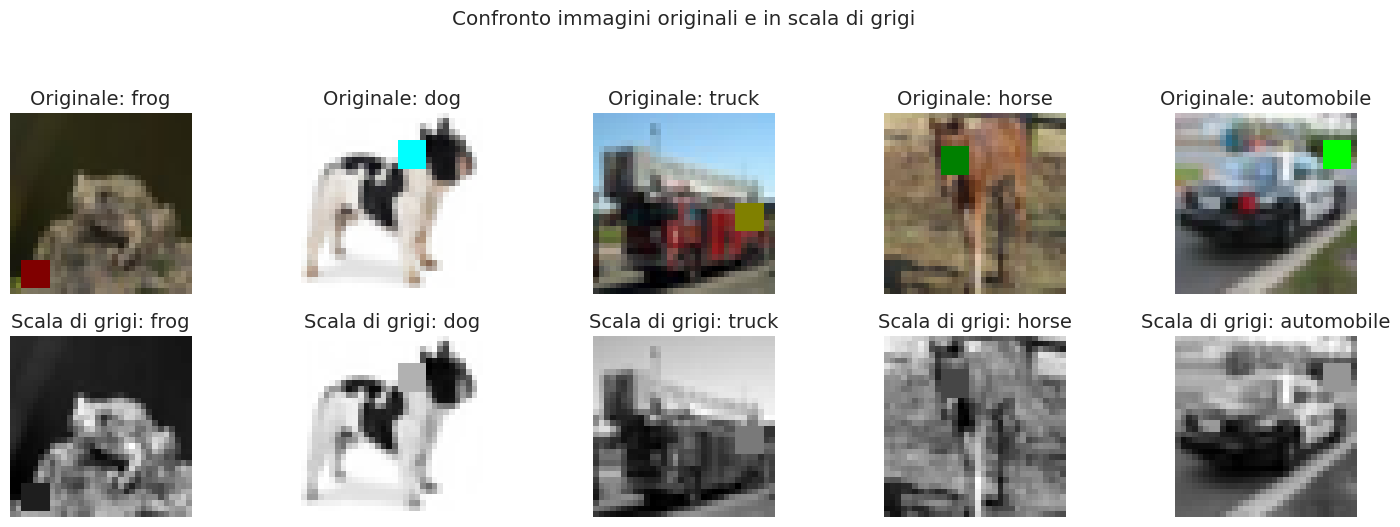

In [40]:
# 2. Preprocessa i dati
X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, class_names = preprocess_data(
    x_train, y_train, x_val, y_val, x_test, y_test
)

In [41]:
# 3. Addestra i modelli
results = train_models(X_train_pca, y_train, X_val_pca, y_val)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to con


######################## SELEZIONE DEL MIGLIOR MODELLO #########################
Criterio: minima differenza tra training accuracy e validation accuracy (min overfitting)


------------------------ PARAMETRI DEL MIGLIOR MODELLO -------------------------
  hidden_layer_sizes: (32, 16)                      
               alpha: 0.1                           
          activation: relu                          
              solver: sgd                           
            max_iter: 100                           
      early_stopping: True                          

--------------------------------- PRESTAZIONI ----------------------------------
   Training Accuracy: 0.4032
 Validation Accuracy: 0.3795
       Test Accuracy: 0.3723
   Training Time (s): 24.94
     Overfitting Gap: 0.0237
--------------------------------------------------------------------------------

============================ CLASSIFICATION REPORT =============================
              precision    recall  f1-

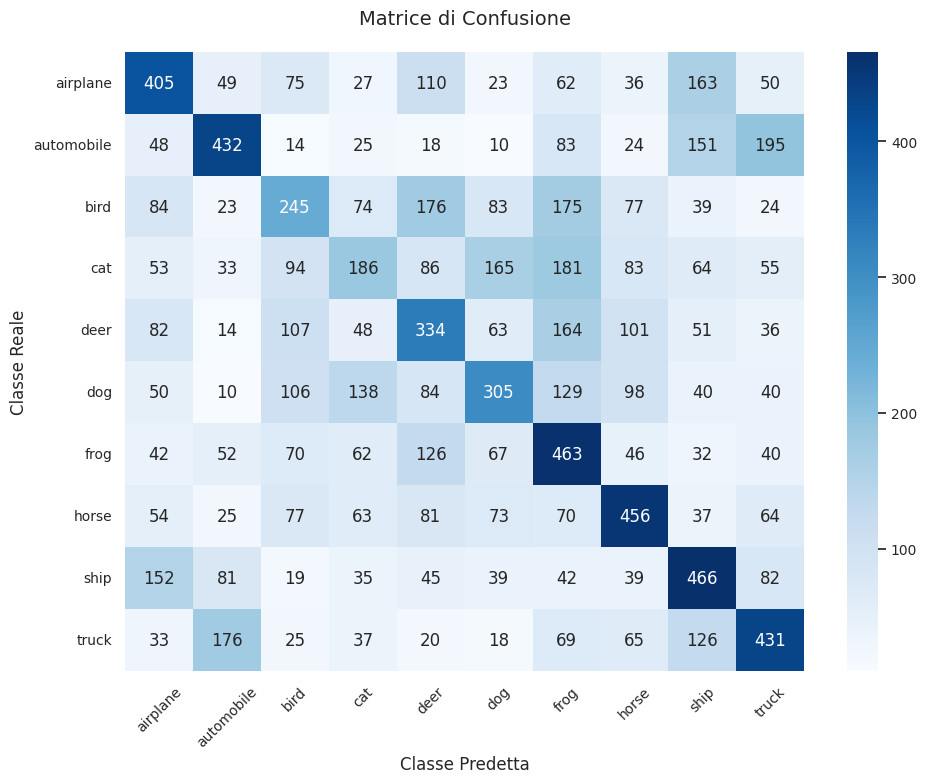

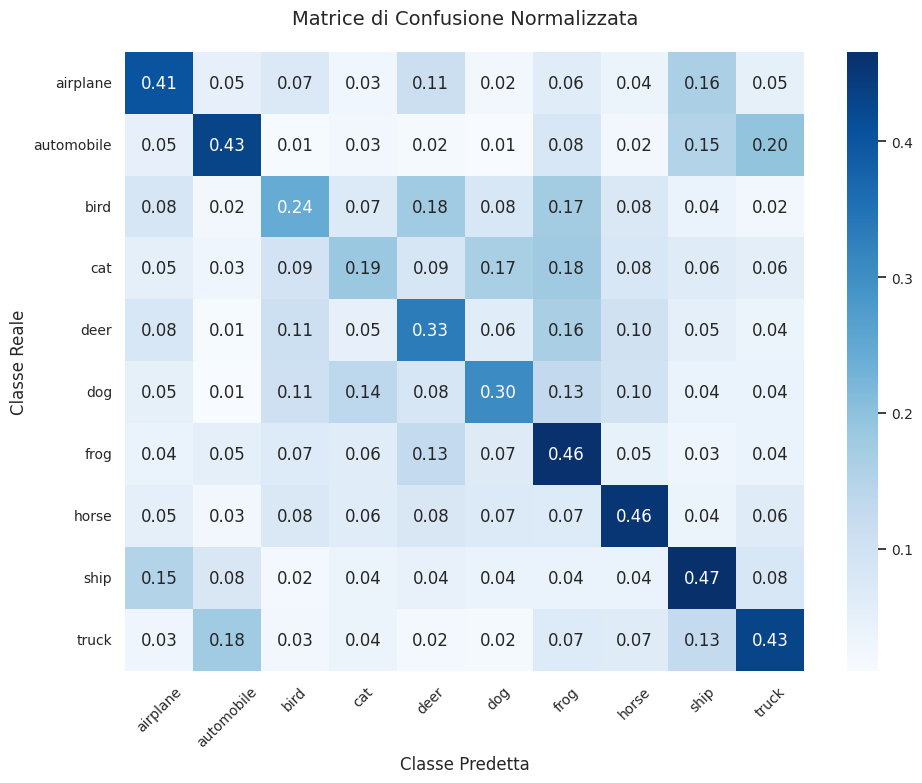

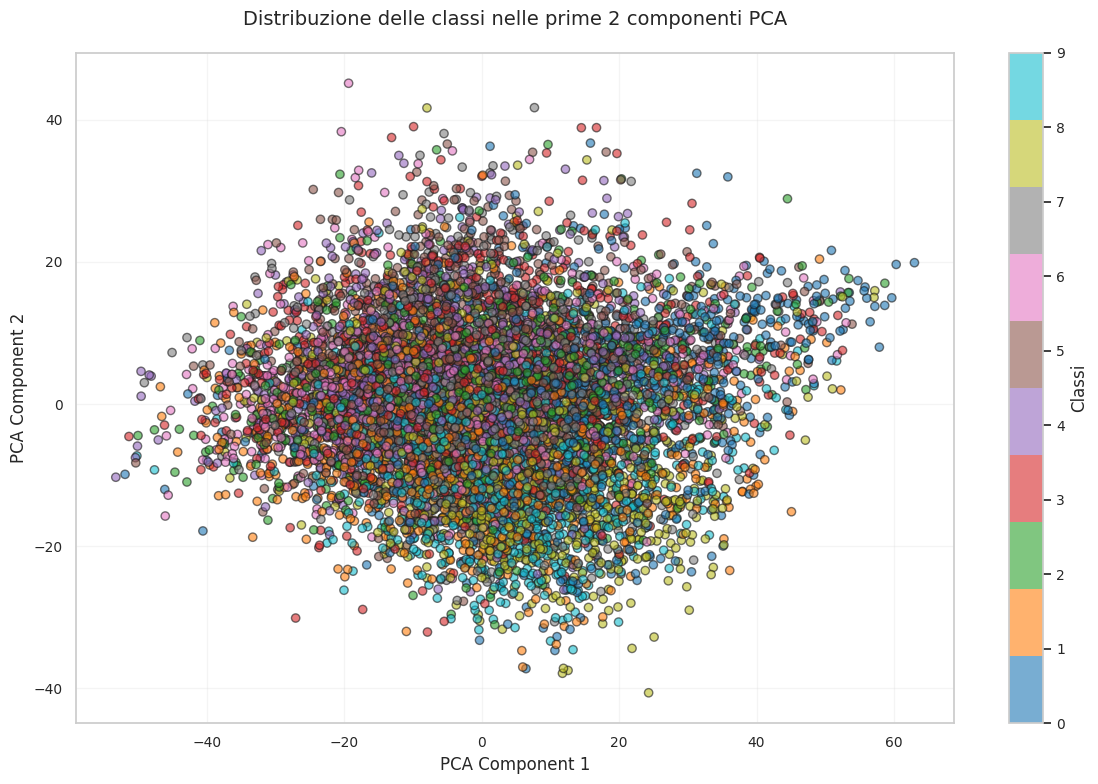

In [48]:
# 4. Trova e valuta il miglior modello con output dettagliato
print("\n" + " SELEZIONE DEL MIGLIOR MODELLO ".center(80, '#'))
print("Criterio: minima differenza tra training accuracy e validation accuracy (min overfitting)\n")

# Trova il miglior modello
best_result = min(results, key=lambda x: x.train_acc - x.val_acc)

# Valutazione completa
evaluate_best_model(best_result, X_test_pca, y_test, class_names)

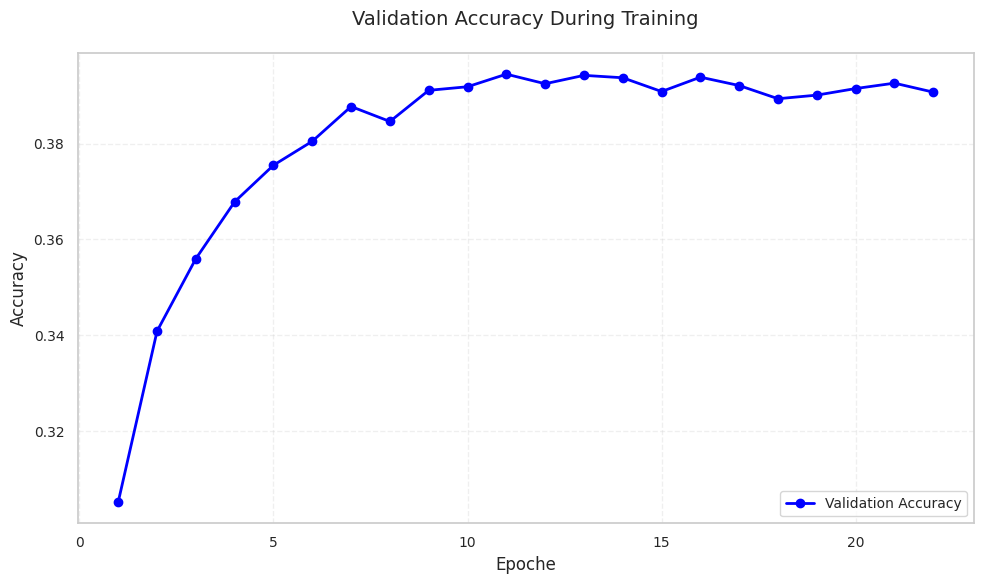

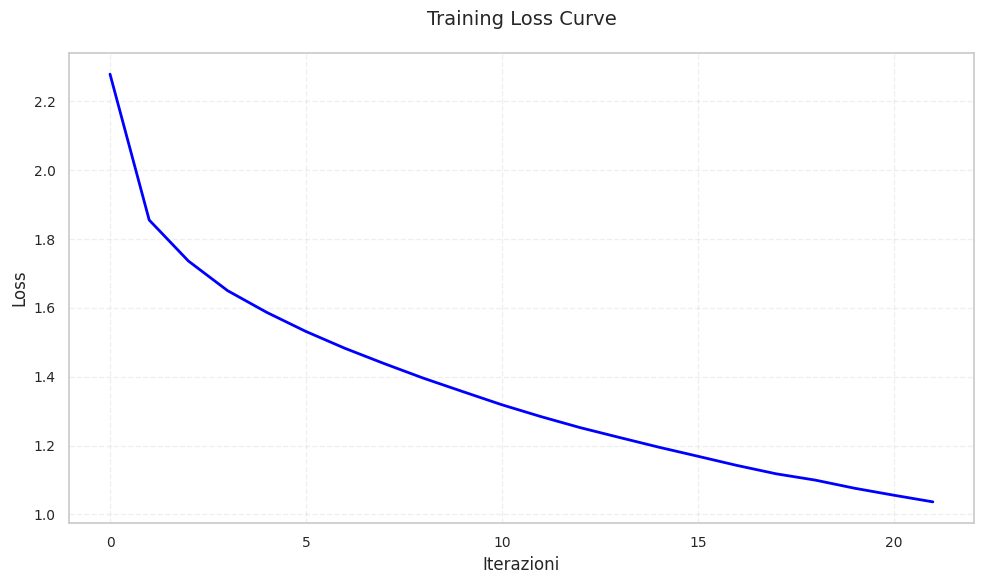

In [49]:
# 5. Visualizza le curve di training (primo modello)
plot_first_training_curve(results)